In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from astropy import units as u
from astropy import constants as const
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.io.ascii as asciitable
from astropy.io import ascii


from __future__ import division
import pandas as pd
import numpy as np
from astropy import units as u
from astropy import constants as const
from astropy.table import Table, join
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.io.ascii as asciitable
from astropy.io import ascii
import astropy.units as au

import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['mathtext.fontset'] = "cm" 



In [2]:
# Define unit conversions
pc=3.09e18
kpc=1e3*pc
msun=1.99e33
myr=3.16e13
g=6.67e-8
msunpc2=msun/pc**2
msunpc2myr=msunpc2/myr

# Choice of CO alpha factor scalings NORMALIZED TO DADDI'S CONVENTIONS
alphasb = 1.0      # starburst value
alphahiz = 1.0     # high-z disk
alphaz0 = 1.0      # z=0 scaling
alphathings = 4.6/4.4 # THINGS data value

# Parameters
sigmagmc=85*msun/pc**2    # GMC surface density in normal galaxies
phip=3.0                  # pressure normalized to isothermal gas disk value
vdisp1=0.8e6                # ISM velocity dispersion in local galaxies
vdisp2=3e6                # ISM velocity dispersion in high-z galaxies and SBs
q=1.0                     # Toomre Q
betasb=1.0                # Index of rotation curve in SBs (solid body)
betadisk=0.0              # Index of rotation curve in normal disks (flat)

# Code for Figure 12 in Cara's paper

In [3]:
# Star Formation Rate vs Gas
cmz_clouds_starFormationRate = Table.read('MEGATABLE.csv').to_pandas()
cmz_clouds_starFormationRate=cmz_clouds_starFormationRate.sort_values('ID')
cmz_clouds_starFormationRate = cmz_clouds_starFormationRate.set_index('ID').reset_index()
cmz_clouds_starFormationRate = cmz_clouds_starFormationRate[['Best SFR estimate','SFR (free fall)', 'SFR CMZoom (Herschel temp)','Total IR SFR', 'Area']]
#drop= cmz_clouds_starFormationRate.index[cmz_clouds_starFormationRate['Best SFR estimate'] == ' ' ]
drop=cmz_clouds_starFormationRate.index[cmz_clouds_starFormationRate['Best SFR estimate'].isnull()]
droplist=drop.tolist()
cmz_clouds_starFormationRate = cmz_clouds_starFormationRate.drop(labels=droplist, axis=0)
cmz_clouds_starFormationRate= cmz_clouds_starFormationRate.drop(cmz_clouds_starFormationRate.index[len(cmz_clouds_starFormationRate)-1]) #drop last row with units


cmz_clouds_physical = Table.read('cmz_cloud_physical_properties.tex').to_pandas()
cmz_clouds_mass = cmz_clouds_physical.set_index('Structure').reset_index()
cmz_clouds_mass = cmz_clouds_mass['Mass']
cmz_clouds_mass = cmz_clouds_mass.drop(labels=0, axis=0)
cmz_clouds_mass = cmz_clouds_mass.reset_index(drop=True)
cmz_clouds_mass = cmz_clouds_mass.drop(labels=droplist, axis=0)


cmz_clouds_area = cmz_clouds_physical.set_index('Structure').reset_index()
cmz_clouds_area = cmz_clouds_area['Area']
cmz_clouds_area = cmz_clouds_area.drop(labels=0, axis=0)
cmz_clouds_area = cmz_clouds_area.reset_index(drop=True)
cmz_clouds_area = cmz_clouds_area.drop(labels=droplist, axis=0)

In [4]:
print(cmz_clouds_starFormationRate)

   Best SFR estimate SFR (free fall) SFR CMZoom (Herschel temp) Total IR SFR  \
0            2.7E-03         2.7E-03                        NaN      1.1E-04   
1            6.0E-08             NaN                        NaN      6.0E-08   
2            6.1E-04         6.1E-04                        NaN      4.8E-06   
4            7.9E-04         7.9E-04                        NaN      1.2E-05   
5            1.6E-03         1.6E-03                        NaN      5.2E-05   
6            1.0E-03         1.0E-03                        NaN      2.6E-05   
7            7.0E-04         7.0E-04                        NaN      6.6E-06   
8            3.5E-02             NaN                        NaN      3.5E-02   
9            3.0E-02             NaN                        NaN      3.0E-02   
10           6.9E-04         6.9E-04                        NaN      9.5E-06   
11           1.3E-02             NaN                        NaN      1.3E-02   
12           1.1E-02             NaN    

In [5]:
print(cmz_clouds_area)

0        70
1         7
2        11
4        32
5        58
6       116
7        17
8     13191
9     10992
10       34
11     6995
12     4996
13     4597
14     3597
15     2598
16       76
17     1259
19     1999
20       66
21      128
22       34
23     1339
24      240
27     1399
28       98
30      102
33      220
36       78
38       20
39      148
40       12
41       22
42       44
43      104
45      164
46       50
47       44
48       54
49        6
51       26
52        9
53       20
54       38
55        8
56       14
Name: Area, dtype: object


In [6]:
#determining which method was used to find the SFR
drop_ffSFR= cmz_clouds_starFormationRate.index[cmz_clouds_starFormationRate['Best SFR estimate'] != cmz_clouds_starFormationRate['SFR (free fall)']].tolist()
ffSFR=(cmz_clouds_starFormationRate.drop(labels=drop_ffSFR, axis=0))
ffSFR=(ffSFR['Best SFR estimate'].values.astype(float)).tolist()
ffmass= cmz_clouds_mass.drop(labels=drop_ffSFR, axis=0).values.astype(float).tolist()
ffarea= cmz_clouds_area.drop(labels=drop_ffSFR, axis=0).values.astype(float).tolist()
ffSFR_list=[]
ffgas=[]
for i in range(len(ffSFR)):
    ffSFR_list.append(ffSFR[i]/(ffarea[i]/1000000))
for i in range(len(ffSFR)):
    ffgas.append(ffmass[i]/ffarea[i])


drop_cmSFR= cmz_clouds_starFormationRate.index[cmz_clouds_starFormationRate['Best SFR estimate'] != cmz_clouds_starFormationRate['SFR CMZoom (Herschel temp)']].tolist()
cmSFR=(cmz_clouds_starFormationRate.drop(labels=drop_cmSFR, axis=0))
cmSFR=(cmSFR['Best SFR estimate'].values.astype(float)).tolist()
cmmass= (cmz_clouds_mass.drop(labels=drop_cmSFR, axis=0)).values.astype(float).tolist()
cmarea= cmz_clouds_area.drop(labels=drop_cmSFR, axis=0).values.astype(float).tolist()
cmSFR_list=[]
cmgas=[]
for i in range(len(cmSFR)):
    cmSFR_list.append(cmSFR[i]/(cmarea[i]/1000000))
for i in range(len(cmSFR)):
    cmgas.append(cmmass[i]/cmarea[i])

cmz_clouds_starFormationRate['Best SFR estimate'] = cmz_clouds_starFormationRate['Best SFR estimate'].astype(float)
cmz_clouds_starFormationRate['Total IR SFR'] = cmz_clouds_starFormationRate['Total IR SFR'].astype(float)
drop_irSFR= cmz_clouds_starFormationRate.index[cmz_clouds_starFormationRate['Best SFR estimate'] != cmz_clouds_starFormationRate['Total IR SFR']].tolist()
irSFR=cmz_clouds_starFormationRate.drop(labels=drop_irSFR, axis=0)
irSFR=(irSFR['Best SFR estimate'].values.astype(float)).tolist()
irmass= cmz_clouds_mass.drop(labels=drop_irSFR, axis=0).values.astype(float).tolist()
irarea= cmz_clouds_area.drop(labels=drop_irSFR, axis=0).values.astype(float).tolist()
irSFR_list=[]
irgas=[]
for i in range(len(irSFR)):
    irSFR_list.append(irSFR[i]/(irarea[i]/1000000))
for i in range(len(irSFR)):
    irgas.append(irmass[i]/irarea[i])

In [7]:
cmz_clouds_starFormationRate['Area']=cmz_clouds_starFormationRate['Area'].values.astype(float)

In [8]:
drop_leaves= cmz_clouds_starFormationRate.index[cmz_clouds_starFormationRate['Area']<4.3e2].tolist()
branches_SFR=(cmz_clouds_starFormationRate.drop(labels=drop_leaves, axis=0))
branches_SFR=(branches_SFR['Best SFR estimate'].values.astype(float)).tolist()
branches_mass= cmz_clouds_mass.drop(labels=drop_leaves, axis=0).values.astype(float).tolist()
branches_area= cmz_clouds_area.drop(labels=drop_leaves, axis=0).values.astype(float).tolist()
branches_list=[]
branches_gas=[]
for i in range(len(branches_SFR)):
    branches_list.append(branches_SFR[i]/(branches_area[i]/1000000))
for i in range(len(branches_SFR)):
    branches_gas.append(branches_mass[i]/branches_area[i])


drop_branches= cmz_clouds_starFormationRate.index[cmz_clouds_starFormationRate['Area']>4.3e2].tolist()
leaves_SFR=(cmz_clouds_starFormationRate.drop(labels=drop_branches, axis=0))
print(leaves_SFR)
leaves_SFR=(leaves_SFR['Best SFR estimate'].values.astype(float)).tolist()
leaves_mass= (cmz_clouds_mass.drop(labels=drop_branches, axis=0)).values.astype(float).tolist()
leaves_area= cmz_clouds_area.drop(labels=drop_branches, axis=0).values.astype(float).tolist()
leaves_list=[]
leaves_gas=[]
for i in range(len(leaves_SFR)):
    leaves_list.append(leaves_SFR[i]/(leaves_area[i]/1000000))
for i in range(len(leaves_SFR)):
    leaves_gas.append(leaves_mass[i]/leaves_area[i])

    Best SFR estimate SFR (free fall) SFR CMZoom (Herschel temp)  \
0        2.700000e-03         2.7E-03                        NaN   
1        6.000000e-08             NaN                        NaN   
2        6.100000e-04         6.1E-04                        NaN   
4        7.900000e-04         7.9E-04                        NaN   
5        1.600000e-03         1.6E-03                        NaN   
6        1.000000e-03         1.0E-03                        NaN   
7        7.000000e-04         7.0E-04                        NaN   
10       6.900000e-04         6.9E-04                        NaN   
16       2.200000e-03         2.2E-03                        NaN   
20       4.600000e-03         4.6E-03                        NaN   
21       5.600000e-03         5.6E-03                        NaN   
22       2.700000e-03         2.7E-03                        NaN   
24       7.700000e-03         7.7E-03                        NaN   
28       4.700000e-03         4.7E-03           

In [9]:
print(leaves_SFR)

[0.0027, 6e-08, 0.00061, 0.00079, 0.0016, 0.001, 0.0007, 0.00069, 0.0022, 0.0046, 0.0056, 0.0027, 0.0077, 0.0047, 0.014, 0.0071, 0.0092, 0.0004, 0.0054, 0.0064, 0.0063, 0.0015, 0.026, 0.0095, 0.0017, 0.005, 0.017, 0.0041, 0.0027, 0.01, 0.0035, 0.0019, 0.00023, 0.0002]


In [10]:
print(np.log10(leaves_list))

[ 1.58626572 -2.06694679  1.74393715  1.39247711  1.44069199  0.93554201
  1.61464912  1.30737017  1.46160909  1.8432139   1.64097806  1.89988485
  1.50627948  1.68087178  2.13752786  1.50883567  2.07169322  1.30103
  1.56213204  2.72699873  2.45691787  1.53263858  2.39794001  1.76287976
  1.53147892  2.05551733  2.49805516  2.83463261  2.01639042  3.04575749
  2.24303805  1.69897     1.45863785  1.15490196]


In [11]:
cmz_clouds_physical = Table.read('cmz_cloud_physical_properties.tex').to_pandas()
print(cmz_clouds_area)

0        70
1         7
2        11
4        32
5        58
6       116
7        17
8     13191
9     10992
10       34
11     6995
12     4996
13     4597
14     3597
15     2598
16       76
17     1259
19     1999
20       66
21      128
22       34
23     1339
24      240
27     1399
28       98
30      102
33      220
36       78
38       20
39      148
40       12
41       22
42       44
43      104
45      164
46       50
47       44
48       54
49        6
51       26
52        9
53       20
54       38
55        8
56       14
Name: Area, dtype: object


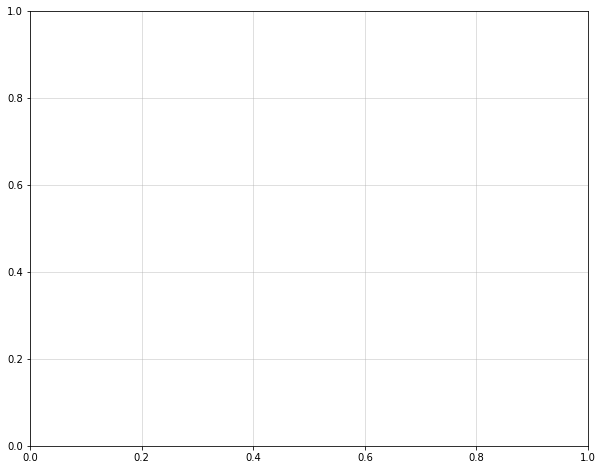

In [12]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.grid(alpha=0.5)

In [13]:
#later used for plotting

sigmag_heid=[]        # Gas surface density
sigmasfr_heid=[]      # SFR surface density

fp=open('./data/heiderman.txt', 'r')
for line in fp:
    spl=line.split()
    sigmag_heid.append(float(spl[14]))
    sigmasfr_heid.append(float(spl[20]))

fp.close()
sigmag_heid = np.array(sigmag_heid)*msun/pc**2
sigmasfr_heid = np.array(sigmasfr_heid)*msun/pc**2/myr

sigmag_heid = np.log10(sigmag_heid/msunpc2)
sigmasfr_heid = np.log10(sigmasfr_heid/msunpc2myr)
sigmag_heid,sigmasfr_heid

(array([1.80821097, 1.76267856, 1.77232171, 1.87506126, 2.0211893 ,
        1.95424251, 2.13987909, 1.96801571, 1.96567197, 1.83695674,
        1.67669361, 1.95951838, 1.96425963, 1.73957234, 1.77158748,
        1.82930377, 1.78031731, 1.69108149, 1.93043959, 2.13353891]),
 array([-0.21824463, -0.43533394,  0.04139269,  0.07554696,  0.38916608,
         0.1172713 ,  0.5171959 , -0.68402965, -0.06854213, -0.11013828,
        -1.44733178,  0.372912  ,  0.5276299 , -0.4225082 , -0.96657624,
         0.22010809, -0.03857891, -0.35654732, -0.46470588,  0.30319606]))

In [14]:
"""literature properties - Lada"""

# Lada data; masses for A_K = 0.1 and 0.8 contours
mass_lada1=np.array([67714., 71828., 99930., 18438., 14964., 14165., 1137., 7937., 2157., 1379., 787.])*msun
mass_lada2=np.array([13721., 7261., 3199., 1880., 1766., 1296., 258., 178., 163., 124., 75.])*msun
sfr_lada=np.array([715., 159., 70., 150., 84., 79., 25., 5., 17., 3., 3.])*msun/myr

sigmag_lada2=116.*2.*msun/pc**2
sigmag_lada1=np.array([sigmag_lada2/8.0]*len(mass_lada2))
area_lada1=mass_lada1/sigmag_lada1
area_lada2=mass_lada2/sigmag_lada2
sigmasfr_lada1=sfr_lada/area_lada1
sigmasfr_lada2=sfr_lada/area_lada2/3.0

sigmag_lada = np.log10(sigmag_lada1/msunpc2)
sigmasfr_lada = np.log10(sigmasfr_lada1/msunpc2myr)

In [15]:
"""literature properties - Genzel"""

sigmag_genzel=[]
sigmasfr_genzel=[]
sigmagtdyn_genzel=[]
sb_genzel=[]
fp=open('./data/genzel_ks.dat', 'r')

for line in fp:
    if line[0]=='#':
        continue
    spl=line.split()
    if spl[0]=='Name':
        continue
    sigmag_genzel.append(10.0**float(spl[11])*msun/pc**2)
    sigmagtdyn_genzel.append(10.0**float(spl[12])/(2.0*np.pi)*msun/pc**2/myr)
    sigmasfr_genzel.append(10.0**float(spl[13])*msun/pc**2/myr)
    # Apply CO scalings
    if spl[0][0:3]=='SMM':
        # sub-mm galaxy, so use starburst scalings; Genzel uses alpha = 1.0
        # for starbursts, and Daddi's convention is 0.8
        sb_genzel.append(True)
        sigmag_genzel[-1] = sigmag_genzel[-1]*0.8/1.0*alphasb
        sigmagtdyn_genzel[-1] = sigmagtdyn_genzel[-1]*0.8/1.0*alphasb
    else:
        # non-sub-mm galaxy, so use normal high z scalings; Genzel uses
        # alpha = 3.2, Daddi uses 3.6
        sb_genzel.append(False)
        sigmag_genzel[-1] = sigmag_genzel[-1]*3.6/3.2*alphahiz
        sigmagtdyn_genzel[-1] = sigmagtdyn_genzel[-1]*3.6/3.2*alphahiz
fp.close()

sigmag_genzel = np.array(sigmag_genzel)
sigmasfr_genzel = np.array(sigmasfr_genzel)

sigmag_genzel = np.log10(sigmag_genzel/msunpc2)
sigmasfr_genzel = np.log10(sigmasfr_genzel/msunpc2myr)

In [16]:
"""literature properties - Bouche"""

sigmag_bouche=[]
sigmasfr_bouche=[]
sigmagtdyn_bouche=[]
fp=open('./data/KS_2_Bouche.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    spl=line.split()
    sigmag_bouche.append(10.0**float(spl[0])*msun/pc**2*alphasb)
    sigmagtdyn_bouche.append(10.0**float(spl[2])/(2.0*np.pi)*msun/pc**2/myr * 
                             alphasb)
    sigmasfr_bouche.append(10.0**float(spl[1])*msun/pc**2/myr)
fp.close()

sigmag_bouche = np.array(sigmag_bouche)
sigmasfr_bouche = np.array(sigmasfr_bouche)

sigmag_bouche = np.log10(sigmag_bouche/msunpc2)
sigmasfr_bouche = np.log10(sigmasfr_bouche/msunpc2myr)

In [17]:
"""literature properties - Daddi z = 0.5"""

sigmag_daddiz05=[]
sigmasfr_daddiz05=[]
sigmagtdyn_daddiz05=[]

fp=open('./data/KS_2_Daddiz05.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    if line[0]=='\n':
        continue
    spl=line.split()
    sigmag_daddiz05.append(10.0**float(spl[1])*msun/pc**2*alphahiz)
    sigmagtdyn_daddiz05.append(10.0**float(spl[2])*msun/pc**2/myr * 
                               alphahiz)
    sigmasfr_daddiz05.append(10.0**float(spl[0])*msun/pc**2/myr)
fp.close()

sigmag_daddiz05 = np.array(sigmag_daddiz05)
sigmasfr_daddiz05 = np.array(sigmasfr_daddiz05)

sigmag_daddiz05 = np.log10(sigmag_daddiz05/msunpc2)
sigmasfr_daddiz05 = np.log10(sigmasfr_daddiz05/msunpc2myr)

In [18]:
"""literature properties - Daddi z = 2"""

sigmag_daddiz2=[]
sigmasfr_daddiz2=[]
sigmagtdyn_daddiz2=[]

fp=open('./data/KS_2_Daddi.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    if line[0]=='\n':
        continue
    spl=line.split()
    sigmag_daddiz2.append(float(spl[0])*msun/pc**2*alphahiz)
    sigmagtdyn_daddiz2.append(float(spl[2])*msun/pc**2/myr *alphahiz)
    sigmasfr_daddiz2.append(float(spl[1])*msun/pc**2/myr)
fp.close()

sigmag_daddiz2 = np.array(sigmag_daddiz2)
sigmasfr_daddiz2 = np.array(sigmasfr_daddiz2)

sigmag_daddiz2 = np.log10(sigmag_daddiz2/msunpc2)
sigmasfr_daddiz2 = np.log10(sigmasfr_daddiz2/msunpc2myr)

In [19]:
"""literature properties - Tacconi"""

sigmag_tacconi=[]
sigmasfr_tacconi=[]
sigmagtdyn_tacconi=[]

fp=open('./data/Tacconi_KS.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    if line[0]=='\n':
        continue
    spl=line.split()
    sigmag_tacconi.append(10.0**float(spl[1])*msun/pc**2*alphahiz)
    sigmagtdyn_tacconi.append(10.0**float(spl[2])*msun/pc**2/myr * 
                              alphahiz)
    sigmasfr_tacconi.append(10.0**float(spl[0])*msun/pc**2/myr)
fp.close()

sigmag_tacconi = np.array(sigmag_tacconi)
sigmasfr_tacconi = np.array(sigmasfr_tacconi)

sigmag_tacconi = np.log10(sigmag_tacconi/msunpc2)
sigmasfr_tacconi = np.log10(sigmasfr_tacconi/msunpc2myr)

In [20]:
"""literature properties - Tacconi 2012"""

name_tacconi12=[]
sigmag_tacconi12=[]
sigmasfr_tacconi12=[]
tdyn_tacconi12=[]
sb_tacconi12=[]

fp=open('./data/tacconi12.txt', 'r')
fp.readline()
fp.readline()
for line in fp:
    spl=line.split()
    if spl[2]=='...':
        continue
    name_tacconi12.append(spl[0])
    sigmag_tacconi12.append(10.**float(spl[-2])*msunpc2)
    sigmasfr_tacconi12.append(10.**float(spl[-1])*msunpc2myr)
    tdyn_tacconi12.append(2*np.pi*float(spl[3])*kpc/(float(spl[2])*1e5))
    sb_tacconi12.append('merger' in spl[1].lower() or 'amor' in spl[1].lower())
fp.close()

sigmag_tacconi12 = np.array(sigmag_tacconi12)
sigmasfr_tacconi12 = np.array(sigmasfr_tacconi12)

sigmag_tacconi12 = np.log10(sigmag_tacconi12/msunpc2)
sigmasfr_tacconi12 = np.log10(sigmasfr_tacconi12/msunpc2myr)

In [21]:
"""literature properties - Kennicutt ULIRG"""

sigmag_kenn_ulirg=[]
sigmasfr_kenn_ulirg=[]
tdyn_kenn_ulirg=[]

fp=open('./data/KS_2_KennUlirgs.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    if line[0]=='\n':
        continue
    spl=line.split()
    if spl[2]=='-1':
        continue
    sigmag_kenn_ulirg.append(10.0**float(spl[0])*msun/pc**2*alphasb)
    sigmasfr_kenn_ulirg.append(10.0**float(spl[1])*msun/pc**2/myr)
    tdyn_kenn_ulirg.append(float(spl[2])*100*myr)
fp.close()

sigmag_kenn_ulirg = np.array(sigmag_kenn_ulirg)
sigmasfr_kenn_ulirg = np.array(sigmasfr_kenn_ulirg)

sigmag_kenn_ulirg = np.log10(sigmag_kenn_ulirg/msunpc2)
sigmasfr_kenn_ulirg = np.log10(sigmasfr_kenn_ulirg/msunpc2myr)

In [22]:
"""literature properties - Kennicutt spiral"""

sigmag_kenn_spiral=[]
sigmasfr_kenn_spiral=[]
tdyn_kenn_spiral=[]

fp=open('./data/KS_2_KennSpirals.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    if line[0]=='\n':
        continue
    spl=line.split()
    if spl[2]=='-1':
        continue
    sigmag_kenn_spiral.append(10.0**float(spl[0])*msun/pc**2*alphasb)
    sigmasfr_kenn_spiral.append(10.0**float(spl[1])*msun/pc**2/myr)
    tdyn_kenn_spiral.append(float(spl[2])*100*myr)
fp.close()

sigmag_kenn_spiral = np.array(sigmag_kenn_spiral)
sigmasfr_kenn_spiral = np.array(sigmasfr_kenn_spiral)

sigmag_kenn_spiral = np.log10(sigmag_kenn_spiral/msunpc2)
sigmasfr_kenn_spiral = np.log10(sigmasfr_kenn_spiral/msunpc2myr)

In [23]:
"""literature properties - Davis 2014"""

data_davis14=ascii.read('./data/DAVIS14_WISEsfrs.txt')

sigmag_davis14 = np.array(data_davis14['Sig_gas'])*msunpc2
sigmasfr_davis14 = np.array(data_davis14['SFR'])*msunpc2myr

sigmag_davis14 = np.log10(sigmag_davis14/msunpc2)
sigmasfr_davis14 = np.log10(sigmasfr_davis14/msunpc2myr)

In [24]:
"""literature properties - Evans 2013"""

evansdat=ascii.read('./data/logsdens.dat')
evansdat1=ascii.read('./data/logsdens1.dat')
evansdat2=ascii.read('./data/logsdensu.dat')

logsigmagtff_evans=evansdat['col1']
logsigmasfr_evans=evansdat['col4']

logsigmagtff_evans1=evansdat1['col1']
logsigmasfr_evans1=evansdat1['col4']
logsigmasfrerr_evans1=evansdat1['col6']

logsigmagtff_evans2=evansdat2['col1']
logsigmasfr_evans2=evansdat2['col4']
logsigmasfrerr_evans2=evansdat2['col6']

In [25]:
"""literature properties - Lada 2013 / Lombardi data"""

ladadat=ascii.read('./data/lombardi3.dat')
arealada=ladadat['AREA'].data*pc**2
sigmaSFRlada=ladadat['NSTARS'].data*0.25*msun/(0.25*myr)/arealada
sigmaSFRerrlada=np.sqrt(ladadat['NSTARS'].data)*0.25*msun/(0.25*myr)/arealada
AKtosigmag = 183*msun/pc**2
sigmaglada=ladadat['AK_MEAN']*AKtosigmag
masslada=sigmaglada*arealada
areadifflada=arealada[:-1]-arealada[1:]
massdifflada=masslada[:-1]-masslada[1:]
sigmaSFRdifflada=(ladadat['NSTARS'].data[:-1] - ladadat['NSTARS'].data[1:]) *0.25*msun/(0.25*myr) / areadifflada
sigmaSFRdifferrlada=np.sqrt(ladadat['NSTARS'].data[:-1] - ladadat['NSTARS'].data[1:]) *0.25*msun/(0.25*myr) / areadifflada
sigmagdifflada=massdifflada/areadifflada

sigmag_lada13 = np.log10(sigmagdifflada/msunpc2)
sigmasfr_lada13 = np.log10(sigmaSFRdifflada/msunpc2myr)

In [26]:
"""literature properties - Gutermuth 2011"""

gutermuthdata=ascii.read('./data/gutermuth11.txt')
area_gutermuth11=gutermuthdata['Area[pc^2]']*pc**2
mass_gutermuth11=gutermuthdata['Mass[msol]']*msun
sigmag_gutermuth11=mass_gutermuth11/area_gutermuth11
nstar_gutermuth11=gutermuthdata['N_II']
sigmasfr_gutermuth11=nstar_gutermuth11*0.5*msun/(2.0*myr)/area_gutermuth11

sigmag_gutermuth11 = np.log10(sigmag_gutermuth11/msunpc2)
sigmasfr_gutermuth11 = np.log10(sigmasfr_gutermuth11/msunpc2myr)

In [27]:
"""literature properties - Wu 2010"""

wudata=ascii.read('./data/wu10.txt')
area_wu10=wudata['Area']*pc**2
sigmag_wu10=10.**wudata['logSig_gas']*msunpc2
sigmasfr_wu10=10.**wudata['logSig_SFR']*msunpc2myr

sigmag_wu10 = np.log10(sigmag_wu10/msunpc2)
sigmasfr_wu10 = np.log10(sigmasfr_wu10/msunpc2myr)

In [28]:
"""literature properties - Bigiel 2008"""

table_B08in = asciitable.read('./data/bigiel08_in.txt', Reader=asciitable.Cds)
table_B08out = asciitable.read('./data/bigiel08_out.txt', Reader=asciitable.Cds)

table_B08in['logGAS'] = np.log10(10**table_B08in['logHI'].quantity.value + 10**table_B08in['logH2'].quantity.value) *table_B08in['logH2'].unit
table_B08out['logSFR'] = np.log10(table_B08out['SFR'].quantity.value *1e-5) *table_B08in['logSFR'].unit

sigmag_bigiel = table_B08in['logGAS']
sigmasfr_bigiel = table_B08in['logSFR']

In [29]:
#creating the "density" effect on graph 

sigmag_all = np.array(np.hstack([sigmag_bigiel, sigmag_heid, sigmag_lada, 
                        sigmag_genzel, sigmag_bouche, sigmag_daddiz05,
                        sigmag_daddiz2, sigmag_tacconi, sigmag_kenn_ulirg,
                        sigmag_kenn_spiral, sigmag_davis14, sigmag_lada13, 
                        sigmag_gutermuth11, sigmag_wu10]))

sigmasfr_all = np.array(np.hstack([sigmasfr_bigiel, sigmasfr_heid, sigmasfr_lada, 
                        sigmasfr_genzel, sigmasfr_bouche, sigmasfr_daddiz05,
                        sigmasfr_daddiz2, sigmasfr_tacconi, sigmasfr_kenn_ulirg,
                        sigmasfr_kenn_spiral, sigmasfr_davis14, sigmasfr_lada13, 
                        sigmasfr_gutermuth11, sigmasfr_wu10]))

sigmag_all = sigmag_all[~np.isinf(sigmasfr_all)]
sigmasfr_all = sigmasfr_all[~np.isinf(sigmasfr_all)]
sigmag_all = sigmag_all[sigmasfr_all!=0]
sigmasfr_all = sigmasfr_all[sigmasfr_all!=0]

x, y = sigmag_all, sigmasfr_all

ax.scatter(x, y, ec='none', fc='black', s=43)
ax.scatter(x, y, ec='none', fc='white', s=30)


#creating the "density" effect on graph for Milky Way CMZ
#gas = np.array(np.hstack([np.log10(gas)]))
#SFR_list = np.array(np.hstack([np.log10(SFR_list)]))

#ax.scatter(gas, SFR_list, ec='none', fc='black', s=43)
#ax.scatter(gas, SFR_list, ec='none', fc='white', s=30)



In [30]:
#plotting points
l_B08 = ax.scatter(sigmag_bigiel, sigmasfr_bigiel, s=30, ec='none', alpha=0.4, c='orange', label="Disc Galaxies")
l_kenn_spiral = ax.scatter(sigmag_kenn_spiral, sigmasfr_kenn_spiral,alpha=0.4, s=30, ec='none', c='orange')
l_davis14 = ax.scatter(sigmag_davis14, sigmasfr_davis14, s=30, ec='none', alpha=0.4, c='orange')

l_kenn_ulirg = ax.scatter(sigmag_kenn_ulirg, sigmasfr_kenn_ulirg, s=30, alpha=0.4,ec='none',  c='blue',label="Starburst Galaxies")

l_genzel = ax.scatter(sigmag_genzel, sigmasfr_genzel, s=30, ec='none', alpha=0.4,c='#bb6Eff', label= "High-redshift Galaxies")
l_bouche = ax.scatter(sigmag_bouche, sigmasfr_bouche, s=30, ec='none', alpha=0.4,c='#bb6Eff')
l_daddiz05 = ax.scatter(sigmag_daddiz05, sigmasfr_daddiz05, s=30, ec='none',alpha=0.4,  c='#bb6Eff')
l_daddiz2 = ax.scatter(sigmag_daddiz2, sigmasfr_daddiz2, s=30, ec='none',alpha=0.4,c='#bb6Eff')
l_tacconi = ax.scatter(sigmag_tacconi, sigmasfr_tacconi, s=30, ec='none', alpha=0.4,c='#bb6Eff')

l_heid = ax.scatter(sigmag_heid, sigmasfr_heid, s=30, ec='none', c='red', alpha=0.4,label= "Milky Way Clouds")
l_lada = ax.scatter(sigmag_lada, sigmasfr_lada, s=30, ec='none',  alpha=0.4,c='red')
l_lada13 = ax.scatter(sigmag_lada13, sigmasfr_lada13, s=30, ec='none',alpha=0.4, c='red')
l_gutermuth11 = ax.scatter(sigmag_gutermuth11, sigmasfr_gutermuth11, s=30,alpha=0.4, ec='none', c='red')
l_wu10 = ax.scatter(sigmag_wu10, sigmasfr_wu10, s=30, ec='none', alpha=0.4,c='red')

#ax.scatter(gas,SFR_list, c='c', ec='none', s=30, alpha=0.4, label="Milky Way CMZ")

#ax.scatter(np.log10(ffgas), np.log10(ffSFR_list), ec='none', fc='black',marker='D', s=43)
#ax.scatter(np.log10(ffgas), np.log10(ffSFR_list), ec='none', fc='white',marker='D', s=30)

#ax.scatter(np.log10(cmgas), np.log10(cmSFR_list), ec='none', fc='black',marker='o', s=43)
#ax.scatter(np.log10(cmgas), np.log10(cmSFR_list), ec='none', fc='white',marker='o', s=30)

#ax.scatter(np.log10(irgas), np.log10(irSFR_list), ec='none', fc='black',marker='X', s=43)
#ax.scatter(np.log10(irgas), np.log10(irSFR_list), ec='none', fc='white',marker='X', s=30)

ax.scatter(np.log10(branches_gas), np.log10(branches_list), ec='none', fc='black',marker='X', s=43)
ax.scatter(np.log10(branches_gas), np.log10(branches_list), ec='none', fc='white',marker='X', s=30)

ax.scatter(np.log10(leaves_gas), np.log10(leaves_list), ec='none', fc='black',marker='o', s=43)
ax.scatter(np.log10(leaves_gas), np.log10(leaves_list), ec='none', fc='white',marker='o', s=30)
#-------------------------------------------------------------------------------------

#plotting points
#ax.scatter(np.log10(ffgas), np.log10(ffSFR_list),c='c', alpha=0.4, s=30, ec='none', marker='D', label='Free fall SFR')
#ax.scatter(np.log10(cmgas), np.log10(cmSFR_list),c='c', alpha=0.4, s=30, ec='none', marker='o',label='CMZoom SFR')
#ax.scatter(np.log10(irgas), np.log10(irSFR_list),c='c', alpha=0.4, s=30, ec='none', marker='X',label='IR SFR')

ax.scatter(np.log10(branches_gas), np.log10(branches_list),c='c', alpha=0.4, s=30, ec='none', marker='X', label='CMZ (branches)')
ax.scatter(np.log10(leaves_gas), np.log10(leaves_list),c='c', alpha=0.4, s=30, ec='none', marker='o',label='CMZ (leaves)')

In [31]:
np.log10(leaves_gas)

array([3.04699656, 2.89526465, 2.94087855, 2.97197128, 2.92676809,
       3.04948536, 2.97367106, 2.97367106, 2.9765189 , 3.12984607,
       3.35518803, 2.89988485, 3.12493874, 2.99104516, 3.53546787,
       3.3651475 , 3.63938431, 3.38916608, 3.3612172 , 3.43933269,
       3.49008623, 3.39794001, 4.09691001, 3.23231418, 3.13353891,
       3.39794001, 3.61002892, 3.71321044, 3.41753556, 3.34678749,
       3.13033377, 2.96428445, 2.85278487, 2.85387196])

In [32]:
np.log10(leaves_list)

array([ 1.58626572, -2.06694679,  1.74393715,  1.39247711,  1.44069199,
        0.93554201,  1.61464912,  1.30737017,  1.46160909,  1.8432139 ,
        1.64097806,  1.89988485,  1.50627948,  1.68087178,  2.13752786,
        1.50883567,  2.07169322,  1.30103   ,  1.56213204,  2.72699873,
        2.45691787,  1.53263858,  2.39794001,  1.76287976,  1.53147892,
        2.05551733,  2.49805516,  2.83463261,  2.01639042,  3.04575749,
        2.24303805,  1.69897   ,  1.45863785,  1.15490196])

In [33]:
#used for error bar

"""Geometry"""

def get_areadisc(R):
    """Surface area (A) of ring with outer radius R"""
    A = np.pi*(R**2)
    return(A)

def get_areaannulus(R, deltaR):
    """Surface area (A) of annulus with outer radius R and width deltaR"""
    A = np.pi*(R**2 - (R-deltaR)**2)
    return(A)

def get_arearectangle(L, H):
    """Surface area (A) of rectangle with length L and height H"""
    A = L*H
    return(A)

def get_surfacedensity(A, p, log=True):
    """Surface area of annulus with outer radius R and width deltaR
    log=True returns log10 units"""
    Sigma = p/A
    if log: 
        Sigma=np.log10(Sigma)
    return(Sigma)

In [34]:
#used for error bar

"""CMZ properties"""

area_flat = get_arearectangle(200, 20)
area = get_areadisc(100) #ring

sfr_CMZ = 0.012
gas_CMZ = 1.8e7

Sigmagas_CMZring_L = get_surfacedensity(area, gas_CMZ)
Sigmasfr_CMZring_L = get_surfacedensity(area, sfr_CMZ)+6 

sfr_CMZ = 0.14
gas_CMZ = 5.3e7

Sigmagas_CMZring_H = get_surfacedensity(area, gas_CMZ)
Sigmasfr_CMZring_H = get_surfacedensity(area, sfr_CMZ)+6

sfr_CMZ = 0.07
gas_CMZ = 3.55e7

Sigmagas_CMZring = get_surfacedensity(area, gas_CMZ)
Sigmasfr_CMZring = get_surfacedensity(area, sfr_CMZ)+6

In [35]:
"""CMZ properties"""

x = Sigmagas_CMZring
y = Sigmasfr_CMZring

xerr = np.array([[(x-Sigmagas_CMZring_L)], [(Sigmagas_CMZring_H-x)]])
yerr = np.array([[(y-Sigmasfr_CMZring_L)], [(Sigmasfr_CMZring_H-y)]])
print(xerr)
print(yerr)

ax.errorbar([x],[y],xerr=xerr,yerr=yerr,
            zorder=11, c='black', 
            capsize=3, 
            elinewidth=2,
            capthick=2)

ax.scatter(x,y, fc='c', ec='black', lw=2, zorder=11)

factor = np.log10((100**2-90**2)/(100**2))

ax.scatter(x-factor,y-factor, fc='c', ec='black', lw=2, zorder=11, s=30, alpha=1, marker='^')


factor = np.log10((200*20)/(np.pi*(100**2)))

ax.scatter(x-factor,y-factor, fc='c', ec='black', lw=2, zorder=11, s=30, alpha=1, marker='s')
ax.plot([x,x-factor], [y,y-factor], c='black', lw=2, ls='--', zorder=2, alpha=1)

[[0.29495585]
 [0.17404752]]
[[0.76591679]
 [0.30103   ]]


In [36]:
print(np.log(leaves_gas))

[7.01596886 6.66659322 6.7716231  6.84321676 6.73913257 7.02169954
 6.84713066 6.84713066 6.85368806 7.20673691 7.72560594 6.67723162
 7.19543735 6.88713599 8.14071562 7.74853846 8.37999207 7.8038433
 7.73948862 7.91935619 8.03622053 7.82404601 9.43348392 7.44267845
 7.21523998 7.82404601 8.31239878 8.54998301 7.86916645 7.70626298
 7.20785987 6.82551718 6.56877991 6.57128304]


In [37]:
print(10**6.66967015)

4673800.277219526


In [38]:
print((leaves_area))

[70.0, 7.0, 11.0, 32.0, 58.0, 116.0, 17.0, 34.0, 76.0, 66.0, 128.0, 34.0, 240.0, 98.0, 102.0, 220.0, 78.0, 20.0, 148.0, 12.0, 22.0, 44.0, 104.0, 164.0, 50.0, 44.0, 54.0, 6.0, 26.0, 9.0, 20.0, 38.0, 8.0, 14.0]


In [39]:
print(np.log(leaves_list))

[ 3.65251181 -4.75932087  4.01556368  3.20629704  3.3173159   2.15416509
  3.71786699  3.01033107  3.3654793   4.24415684  3.77849161  4.37464653
  3.46833668  3.87035031  4.9218398   3.47422252  4.77024994  2.99573227
  3.59694196  6.27914662  5.65726246  3.52903075  5.52146092  4.05918065
  3.52636052  4.73300356  5.75198458  6.52698278  4.64291051  7.01311579
  5.16478597  3.91202301  3.35863777  2.65926004]


In [40]:
print((leaves_mass))

[78000.0, 5500.0, 9600.0, 30000.0, 49000.0, 130000.0, 16000.0, 32000.0, 72000.0, 89000.0, 290000.0, 27000.0, 320000.0, 96000.0, 350000.0, 510000.0, 340000.0, 49000.0, 340000.0, 33000.0, 68000.0, 110000.0, 1300000.0, 280000.0, 68000.0, 110000.0, 220000.0, 31000.0, 68000.0, 20000.0, 27000.0, 35000.0, 5700.0, 10000.0]


In [41]:
print((leaves_SFR))

[0.0027, 6e-08, 0.00061, 0.00079, 0.0016, 0.001, 0.0007, 0.00069, 0.0022, 0.0046, 0.0056, 0.0027, 0.0077, 0.0047, 0.014, 0.0071, 0.0092, 0.0004, 0.0054, 0.0064, 0.0063, 0.0015, 0.026, 0.0095, 0.0017, 0.005, 0.017, 0.0041, 0.0027, 0.01, 0.0035, 0.0019, 0.00023, 0.0002]


In [42]:
print(np.log(branches_list))

[ 0.97581328  1.00402965  0.61975375  0.78925768  0.77718118  0.84813154
  0.96218069  1.35891745  1.79225959 -0.76995887  1.8942567 ]


In [43]:
gas=np.linspace(-1e2,1e5,10000)
kennicutSFR=np.log10(2.5e-4*(gas**1.4))
ax.plot(np.log10(gas),kennicutSFR,c='k',linestyle='dashed' ,label='Kennicutt (1998)')
ax.set_xlim(0,5)

a=-3.1
n=1
gas=np.linspace(-1e2,1e5,10000)
#bigielSFR=np.log10((10**-2.1)*(gas**1.0))
bigielSFR=np.log10((10**a)*(gas**n))
ax.plot(np.log10(gas),bigielSFR,c='k', linestyle='dotted',label='Bigiel et al. (2008)')
ax.set_xlim(0,5)
ax.set_ylim(-4,4)

(-4.0, 4.0)

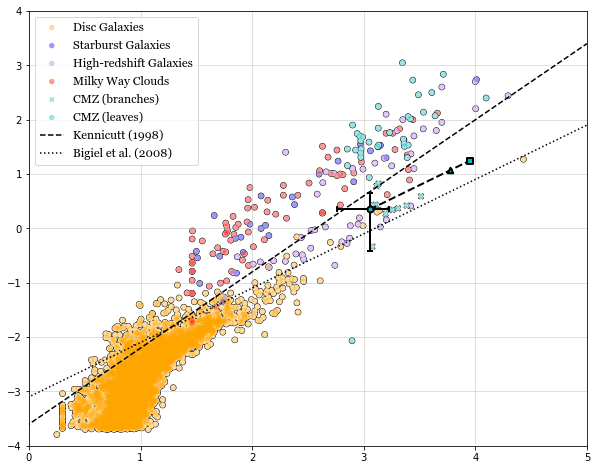

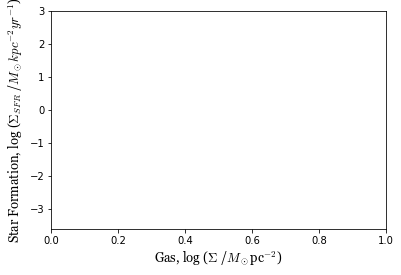

In [44]:

plt.ylabel('Star Formation, log ($\Sigma_{SFR}$ /$M_\odot$$kpc^{-2}yr^{-1}$)', **{'fontname':'Georgia'}, fontsize=13)
plt.xlabel('Gas, log ($\Sigma$ /$M_\odot$pc$^{-2}$)',**{'fontname':'Georgia'},fontsize=13)
mpl.rc('font', family='Georgia')
plt.ylim(-3.6,3)

mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 
ax.legend(loc='upper left',fontsize=12)
fig

In [45]:
fig.savefig('SFRvsGas.pdf')